In [1]:
regional_key = '09663'

import sys
sys.path.append('/Users/felix/Documents/thesis')

import pharmada.data as data


In [2]:
data = data.Data(regional_key)
data

Pharmada model data for Kreisfreie Stadt Würzburg (09663).
Pharmacies in area: 42.
Customers in area:  5313.

In [3]:
import geopandas as gpd
from scipy.spatial import cKDTree
import numpy as np
from shapely.geometry import Point, MultiPoint

# Assuming df1 and df2 are your dataframes and they have a 'geometry' column with Point geometries

# Reproject dataframes to a metric CRS (if they aren't in one already) for correct distance calculation
crs = data.AreaGeometry.geometry.estimate_utm_crs()
customers = data.Customers.customers.to_crs(crs)
pharmacies = data.Pharmacies.pharmacies.to_crs(crs)

def closest(point, points):
    """Return closest point from a list of points."""
    return points[np.argmin([point.distance(p) for p in points])]

# Create cKDTree object
tree = cKDTree(pharmacies.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())

# Find indices of the nearest pharmacy for each customer
distances, indices = tree.query(customers.geometry.apply(lambda geom: (geom.x, geom.y)).tolist(), k=1)

# Add nearest pharmacy id to customer df
customers['nearest_pharmacy'] = indices.tolist()


In [ ]:
results = []

# Assign customers to pharmacies and write results to GeoDataFrame
for pharmacy_id in pharmacies.index:
    customers_at_pharmacy = customers.loc[customers["nearest_pharmacy"] == pharmacy_id, "geometry"]
    if not customers_at_pharmacy.empty:
        results.append({"pharmacy_id": pharmacy_id, "customers": MultiPoint(customers_at_pharmacy.tolist())})

results = gpd.GeoDataFrame(results)
results.set_geometry("customers", inplace=True)

# Convert 'pharmacy_id' to int and 'customers' to GeoSeries
results["pharmacy_id"] = results["pharmacy_id"].astype(int)
results["customers"] = gpd.GeoSeries(results["customers"])

# Set the CRS for the GeoDataFrame to match the input DataFrames
results.set_crs(crs, inplace=True)  # adjust this to match your CRS

In [5]:
num_cus = results.apply(lambda x: len(x['customers'].geoms), axis=1)
pharmacies['num_cus'] = num_cus
pharmacies.explore()

In [ ]:
customers.groupby('nearest_pharmacy')
customers.plot(cmap='tab20', column='nearest_pharmacy', legend=True, figsize=(10, 10))

In [38]:
test = customers.groupby('nearest_pharmacy').aggregate({'geometry': lambda x: MultiPoint(x.tolist())})

<Axes: >

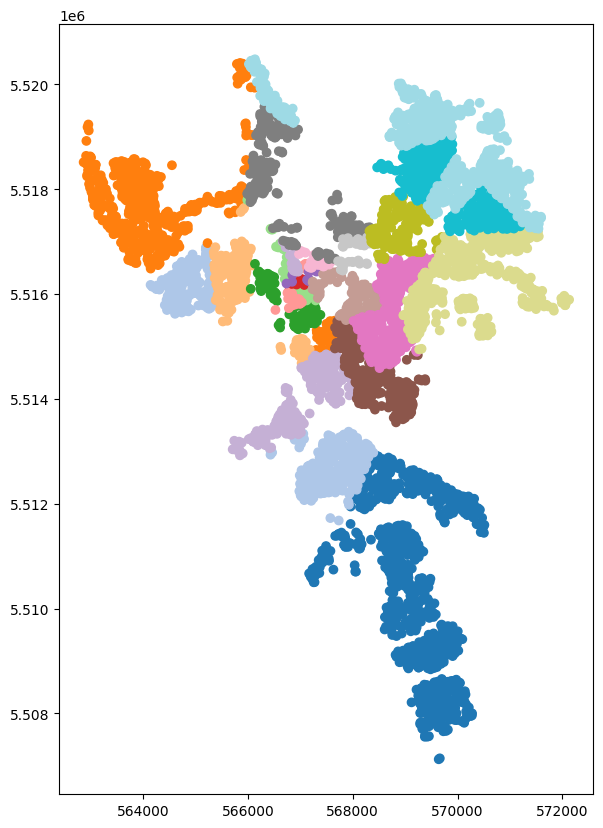

In [42]:
test.set_geometry('geometry', inplace=True)
test.plot(cmap='tab20', figsize=(10, 10))